In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, optimizers, regularizers
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
from sklearn import set_config
import sys, os

sys.path.append( os.path.abspath('custom_functions'))
set_config(transform_output='pandas')
pd.set_option('display.max_colwidth', 200)

%load_ext autoreload 
%autoreload 2

import custom_functions as fn

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import joblib
df = joblib.load('Data_NLP/processed_reviews_v2.joblib')
df.info()
df.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7254 entries, 0 to 8649
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   review_id       7254 non-null   object
 1   movie_id        7254 non-null   int64 
 2   imdb_id         7254 non-null   object
 3   original_title  7254 non-null   object
 4   review          7254 non-null   object
 5   new_rating      2026 non-null   object
 6   lower_review    7254 non-null   object
 7   tokens          7254 non-null   object
 8   clean_tokens    7254 non-null   object
 9   spacy_lemmas    7254 non-null   object
 10  tokens_joined   7254 non-null   object
 11  lemmas_joined   7254 non-null   object
dtypes: int64(1), object(11)
memory usage: 736.7+ KB


,review_id,movie_id,imdb_id,original_title,review,new_rating,lower_review,tokens,clean_tokens,spacy_lemmas,tokens_joined,lemmas_joined
0,64ecc16e83901800af821d50,843,tt0118694,花樣年華,This is a fine piece of cinema from Wong Kar-Wai that tells us a story of two people whom circumstance throws together - but not in a way you might expect. We start with two couples who move into ...,None,this is a fine piece of cinema from wong kar-wai that tells us a story of two people whom circumstance throws together - but not in a way you might expect. we start with two couples who move into ...,"[this, is, a, fine, piece, of, cinema, from, wong, kar-wai, that, tells, us, a, story, of, two, people, whom, circumstance, throws, together, -, but, not, in, a, way, you, might, expect, ., we, st...","[fine, piece, cinema, wong, kar-wai, tells, us, story, two, people, circumstance, throws, together, way, might, expect, start, two, couples, move, new, building, one, newspaper, man, wife, busines...","[fine, piece, cinema, wong, kar, wai, tell, story, people, circumstance, throw, way, expect, start, couple, new, building, newspaper, man, wife, business, executive, wife, businessman, rarely, hom...",fine piece cinema wong kar-wai tells us story two people circumstance throws together way might expect start two couples move new building one newspaper man wife business executive wife businessma...,fine piece cinema wong kar wai tell story people circumstance throw way expect start couple new building newspaper man wife business executive wife businessman rarely home journalist wife leave in...
1,57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommende...",High,"a guilty pleasure for me personally, as i love both 'the great escape' and most of the works i have seen, over the years, from this rightfully-esteemed british animation company. highly recommende...","[a, guilty, pleasure, for, me, personally, ,, as, i, love, both, 'the, great, escape, ', and, most, of, the, works, i, have, seen, ,, over, the, years, ,, from, this, rightfully-esteemed, british,...","[guilty, pleasure, personally, love, 'the, great, escape, works, seen, years, rightfully-esteemed, british, animation, company, highly, recommended, children, adults, enjoy, animation]","[guilty, pleasure, personally, love, great, escape, work, see, year, rightfully, esteem, british, animation, company, highly, recommend, child, adult, enjoy, animation]",guilty pleasure personally love 'the great escape works seen years rightfully-esteemed british animation company highly recommended children adults enjoy animation,guilty pleasure personally love great escape work see year rightfully esteem british animation company highly recommend child adult enjoy animation
4,64ecc027594c9400ffe77c91,7443,tt0120630,Chicken Run,"Ok, there is an huge temptation to riddle this review with puns - but I'm just going to say it's a cracking little family adventure. It's seemingly based on a whole range of classic movies from th...",None,"ok, there is an huge temptation to riddle this review with puns - but i'm just going to say it's a cracking little family adventure. it's seemingly based on a whole range of classic movies from th...","[ok, ,, there, is, an, huge, temptation, to, riddle, this, review, with, puns, -, but, i, 'm, just, going, to, say, it, 's, a, cracking, little, family, adventure, ., it, 's, seemingly, based, on,...","[ok, huge, temptation, riddle, review, puns, 'm, going, say, 's, cracking, little, family, adventure, 's, seemingly, based, whole, range, classic, movies, ``, great, escape, '', ``, star, trek, ''...","[ok, huge, temptation, riddle, review, pun, go, crack, little, family, adventure, seemingly, base, range, classic, movie, great, escape, star, trek, love, story, score, cannibalise, write, messrs....",ok h

In [4]:
df.shape

(7254, 12)

In [5]:
df['new_rating'].isna().sum()

5228

In [6]:
df = df.dropna()
df.head(3)

,review_id,movie_id,imdb_id,original_title,review,new_rating,lower_review,tokens,clean_tokens,spacy_lemmas,tokens_joined,lemmas_joined
1,57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommende...",High,"a guilty pleasure for me personally, as i love both 'the great escape' and most of the works i have seen, over the years, from this rightfully-esteemed british animation company. highly recommende...","[a, guilty, pleasure, for, me, personally, ,, as, i, love, both, 'the, great, escape, ', and, most, of, the, works, i, have, seen, ,, over, the, years, ,, from, this, rightfully-esteemed, british,...","[guilty, pleasure, personally, love, 'the, great, escape, works, seen, years, rightfully-esteemed, british, animation, company, highly, recommended, children, adults, enjoy, animation]","[guilty, pleasure, personally, love, great, escape, work, see, year, rightfully, esteem, british, animation, company, highly, recommend, child, adult, enjoy, animation]",guilty pleasure personally love 'the great escape works seen years rightfully-esteemed british animation company highly recommended children adults enjoy animation,guilty pleasure personally love great escape work see year rightfully esteem british animation company highly recommend child adult enjoy animation
7,5e9120963679a10018375490,955,tt0120755,Mission: Impossible II,After quite entertainign Mission Impossible I the second installment turned out ... terrible. As if the screenwriters didn't know how to fill the 2 hrs with action the overuse of heroic slow motio...,Low,after quite entertainign mission impossible i the second installment turned out ... terrible. as if the screenwriters didn't know how to fill the 2 hrs with action the overuse of heroic slow motio...,"[after, quite, entertainign, mission, impossible, i, the, second, installment, turned, out, ..., terrible, ., as, if, the, screenwriters, did, n't, know, how, to, fill, the, 2, hrs, with, action, ...","[quite, entertainign, mission, impossible, second, installment, turned, ..., terrible, screenwriters, n't, know, fill, 2, hrs, action, overuse, heroic, slow, motion, scenes, horrible, almost, migh...","[entertainign, mission, impossible, second, installment, turn, terrible, screenwriter, know, fill, 2, hrs, action, overuse, heroic, slow, motion, scene, horrible, need, barf, bag, stand, slo, mo, ...",quite entertainign mission impossible second installment turned ... terrible screenwriters n't know fill 2 hrs action overuse heroic slow motion scenes horrible almost might need barf bag ca n't s...,entertainign mission impossible second installment turn terrible screenwriter know fill 2 hrs action overuse heroic slow motion scene horrible need barf bag stand slo mo second 15 second amazed de...
15,608e2744d8cc4a0058dc4272,2621,tt0122459,Return to Me,"Okay, I will admit I can be a bit of an easy grader when it comes to romantic comedies, as long as they are witty with likable characters, don’t insult my intelligence and have suitable happy endi...",High,"okay, i will admit i can be a bit of an easy grader when it comes to romantic comedies, as long as they are witty with likable characters, don’t insult my intelligence and have suitable happy endi...","[okay, ,, i, will, admit, i, can, be, a, bit, of, an, easy, grader, when, it, comes, to, romantic, comedies, ,, as, long, as, they, are, witty, with, likable, characters, ,, don, ’, t, insult, my,...","[okay, admit, bit, easy, grader, comes, romantic, comedies, long, witty, likable, characters, ’, insult, intelligence, suitable, happy, endings, guess, ’, end, happily, ’, rom-coms, saw, movie, ma...","[okay, admit, bit, easy, grader, come, romantic, comedy, long, witty, likable, character, insult, intelligence, suitable, happy, ending, guess, end, happily, rom, com, see, movie, year, 

In [7]:
df.shape

(2026, 12)

In [8]:
#Splitting data for machine learning
X = df['review']
y = df['new_rating']

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=.3, random_state=42)
len(X_train_full), len(X_test)

(1418, 608)

In [29]:
count_vectorizer = CountVectorizer()
count_vectorizer.fit(X_train_full)

CountVectorizer()

In [32]:
nbayes = MultinomialNB()

count_pipe = Pipeline([('vectorizer', count_vectorizer), 
                       ('clf', nbayes)])

count_pipe.fit(X_train_full, y_train_full)

Pipeline(steps=[('vectorizer', CountVectorizer()), ('clf', MultinomialNB())])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        High       0.99      0.97      0.98       720
         Low       0.97      0.99      0.98       698

    accuracy                           0.98      1418
   macro avg       0.98      0.98      0.98      1418
weighted avg       0.98      0.98      0.98      1418



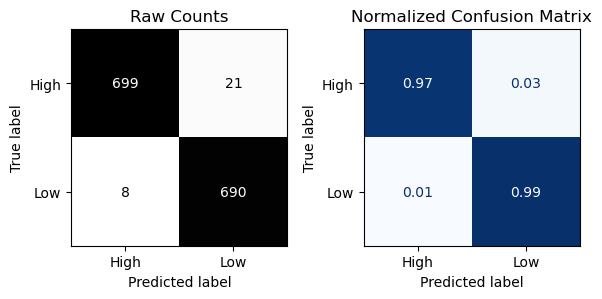


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        High       0.89      0.84      0.87       316
         Low       0.84      0.89      0.86       292

    accuracy                           0.87       608
   macro avg       0.87      0.87      0.87       608
weighted avg       0.87      0.87      0.87       608



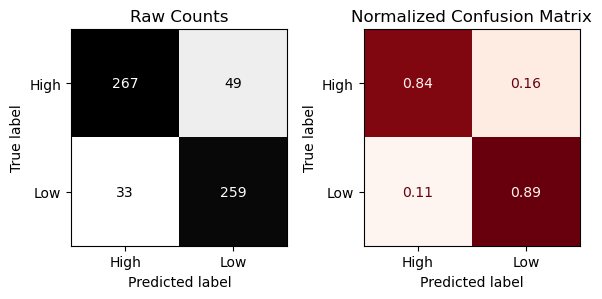

In [35]:
fn.evaluate_classification(count_pipe, X_train_full, y_train_full, X_test, y_test)

In [36]:
gs_pipe = Pipeline([('vectorizer',CountVectorizer()),
                    ('clf',MultinomialNB())])
gs_pipe.get_params()

{'memory': None,
 'steps': [('vectorizer', CountVectorizer()), ('clf', MultinomialNB())],
 'verbose': False,
 'vectorizer': CountVectorizer(),
 'clf': MultinomialNB(),
 'vectorizer__analyzer': 'word',
 'vectorizer__binary': False,
 'vectorizer__decode_error': 'strict',
 'vectorizer__dtype': numpy.int64,
 'vectorizer__encoding': 'utf-8',
 'vectorizer__input': 'content',
 'vectorizer__lowercase': True,
 'vectorizer__max_df': 1.0,
 'vectorizer__max_features': None,
 'vectorizer__min_df': 1,
 'vectorizer__ngram_range': (1, 1),
 'vectorizer__preprocessor': None,
 'vectorizer__stop_words': None,
 'vectorizer__strip_accents': None,
 'vectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'vectorizer__tokenizer': None,
 'vectorizer__vocabulary': None,
 'clf__alpha': 1.0,
 'clf__class_prior': None,
 'clf__fit_prior': True,
 'clf__force_alpha': 'warn'}

In [38]:
# Define params to try for both vectorizers
param_grid_shared = {
    "vectorizer__max_df": [0.7, 0.8, 0.9],
    'vectorizer__min_df': [ 2, 3, 4, 5 ], 
    "vectorizer__max_features": [None, 1000, 2000],
    "vectorizer__stop_words": [None,'english'],
    "vectorizer__ngram_range": [(1, 1), (1, 2),(2,2)]
}

# Setting params for the count vectorizer
param_grid_count = {
    'vectorizer':[CountVectorizer()],
    **param_grid_shared
}


# Setting params for tfidf vectorizer 
param_grid_tfidf = {
    'vectorizer': [TfidfVectorizer()],
    "vectorizer__norm": ["l1", "l2"],
    "vectorizer__use_idf": [True, False],
    **param_grid_shared
}

# combine into list of params
params_combined = [param_grid_count, param_grid_tfidf]
params_combined

[{'vectorizer': [CountVectorizer()],
  'vectorizer__max_df': [0.7, 0.8, 0.9],
  'vectorizer__min_df': [2, 3, 4, 5],
  'vectorizer__max_features': [None, 1000, 2000],
  'vectorizer__stop_words': [None, 'english'],
  'vectorizer__ngram_range': [(1, 1), (1, 2), (2, 2)]},
 {'vectorizer': [TfidfVectorizer()],
  'vectorizer__norm': ['l1', 'l2'],
  'vectorizer__use_idf': [True, False],
  'vectorizer__max_df': [0.7, 0.8, 0.9],
  'vectorizer__min_df': [2, 3, 4, 5],
  'vectorizer__max_features': [None, 1000, 2000],
  'vectorizer__stop_words': [None, 'english'],
  'vectorizer__ngram_range': [(1, 1), (1, 2), (2, 2)]}]

In [40]:
# Create grid search
grid_search = GridSearchCV(gs_pipe, params_combined, cv=3, verbose=1, n_jobs=-1)
    
    
# Fit the model
grid_search.fit(X_train_full, y_train_full)
grid_search.best_params_

Fitting 3 folds for each of 1080 candidates, totalling 3240 fits


{'vectorizer': TfidfVectorizer(max_df=0.9, min_df=5, ngram_range=(1, 2)),
 'vectorizer__max_df': 0.9,
 'vectorizer__max_features': None,
 'vectorizer__min_df': 5,
 'vectorizer__ngram_range': (1, 2),
 'vectorizer__norm': 'l2',
 'vectorizer__stop_words': None,
 'vectorizer__use_idf': True}

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        High       0.99      0.96      0.98       720
         Low       0.96      0.99      0.98       698

    accuracy                           0.98      1418
   macro avg       0.98      0.98      0.98      1418
weighted avg       0.98      0.98      0.98      1418



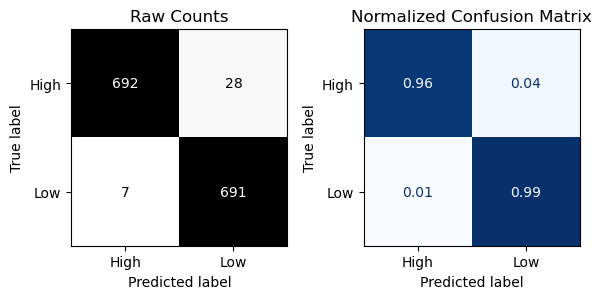


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        High       0.92      0.84      0.87       316
         Low       0.84      0.92      0.88       292

    accuracy                           0.88       608
   macro avg       0.88      0.88      0.87       608
weighted avg       0.88      0.88      0.87       608



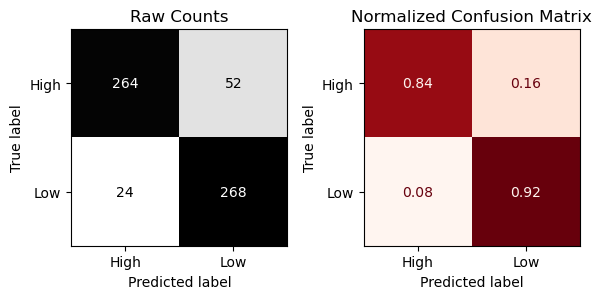

In [43]:
best_gs_pipe = grid_search.best_estimator_
fn.evaluate_classification(best_gs_pipe, X_train_full, y_train_full, X_test, y_test)

The best parameters is a count vectorizer with the following:
- max_df = .9
- min_df = 5
- ngram_range = (1,2)
- stopwords = None

The best estimators performed better than our initial model.

In [50]:
#Instansiate label encoder
encoder = LabelEncoder()

#Fit and transform the target
y_train_full_enc = encoder.fit_transform(y_train_full)
y_test_enc = encoder.transform(y_test)

y_train_full_enc[:10]

array([1, 1, 0, 0, 1, 1, 1, 1, 1, 1])

In [51]:
classes = y.unique()
classes

array(['High', 'Low'], dtype=object)

In [52]:
y.value_counts(normalize=True)

High    0.511352
Low     0.488648
Name: new_rating, dtype: float64

In [53]:
#Convert training data to Dataset Object
train_ds = tf.data.Dataset.from_tensor_slices((X_train_full, y_train_full_enc))
# Shuffle dataset once
train_ds = train_ds.shuffle(len(train_ds),seed=42, reshuffle_each_iteration=False)

In [54]:
#Convert test to dataset object to split
val_test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test_enc))

#Calculate # of samples for 50/50 val/test split
n_val_samples = int(len(val_test_ds) *.5)
n_val_samples

304

In [55]:
#Creating validation dataset using .take
val_ds = val_test_ds.take(n_val_samples)
#Creating test dataset using .skip
test_ds = val_test_ds.skip(n_val_samples)

#Comparing the len gths of all 3 splits
len(train_ds), len(val_ds), len(test_ds)

(1418, 304, 304)

In [56]:
#  Setting the batch_size for all datasets
BATCH_SIZE =32
# use .batch to add batching to all 3 datasets
train_ds = train_ds.batch(BATCH_SIZE)
val_ds = val_ds.batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)

# Confirm the number of batches in each
print (f' There are {len(train_ds)} training batches.')
print (f' There are {len(val_ds)} validation batches.')
print (f' There are {len(test_ds)} testing batches.')

 There are 45 training batches.
 There are 10 validation batches.
 There are 10 testing batches.


In [57]:
train_ds

<_BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [58]:
# Get just the text_ds from train_ds
text_ds = train_ds.map(lambda x,y: x)
# Preview the text_ds
text_ds.take(1).get_single_element()

<tf.Tensor: shape=(32,), dtype=string, numpy=
array([b'Is there any excuse available that will justify spending 2 hours, 45 minutes to watch this film?  Or why I am gifting it three stars?\r\n\r\nIt was a free rental at Redox.\r\nI normally enjoy Mark Wahlberg movies.\r\nI love Bumblebee.  \r\n\r\nDo any of these hold water?\r\n\r\nI know one thing that doesn\xe2\x80\x99t hold a lot of water \xe2\x80\x93 the story. Does it really matter at this point in the franchise? There are good guy Transformers called Autobots and bad guy Transformers called Decepticons and standing between them are stupid humans that betray their species for profit \xe2\x80\x93 normally it\xe2\x80\x99s the U.S. Government. BUT wait \xe2\x80\x93 there is one hero that will change all of this and talk Optimus Prime (Autobot Boss Daddy) into fighting one last battle (for the fourth or fifth time \xe2\x80\x93 I\xe2\x80\x99ve lost count at this point) while some hot-looking woman runs around explosions in short-shorts

In [59]:
df['length'] = df['tokens'].map(len)
df['length'].describe()

count    2026.000000
mean      267.187068
std       273.928826
min         1.000000
25%        74.000000
50%       180.000000
75%       360.000000
max      2593.000000
Name: length, dtype: float64

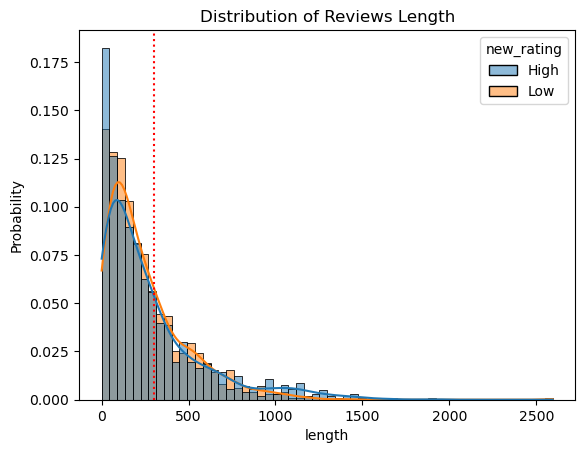

In [60]:
SEQUENCE_LENGTH = 300
ax = sns.histplot(data=df, hue='new_rating', x='length',kde=True,
                stat='probability',common_norm=False)#, estimator='median',);
ax.axvline(SEQUENCE_LENGTH, color='red', ls=":")
ax.set_title('Distribution of Reviews Length');

In [61]:
sequence_vectorizer = tf.keras.layers.TextVectorization(standardize="lower_and_strip_punctuation",
                                                        output_mode="int",
                                                        output_sequence_length=SEQUENCE_LENGTH)

sequence_vectorizer.adapt(text_ds)
VOCAB_SIZE = sequence_vectorizer.vocabulary_size()
VOCAB_SIZE

23062

In [62]:
def build_rnn_model(text_vectorization_layer):
    
    # Getting Text Parameters from TextVectorization Layer
    VOCAB_SIZE = text_vectorization_layer.vocabulary_size()
    SEQUENCE_LENGTH = text_vectorization_layer.get_config()['output_sequence_length']
    
    
    # Define sequential model with pre-trained vectorization layer and *new* embedding layer
    model = Sequential([
        text_vectorization_layer,
        layers.Embedding(input_dim=VOCAB_SIZE,
                                  output_dim=EMBED_DIM, 
                                  input_length=SEQUENCE_LENGTH)
        ])
        
    # Add the SimpleRNN layer
    model.add(layers.SimpleRNN(32))
    
    # Add output layer
    model.add(layers.Dense(1, activation='sigmoid'))
 
    # Compile the model
    model.compile(optimizer=optimizers.legacy.Adam(learning_rate = .001), 
                  loss='bce',
                  metrics=['accuracy'])
    
    model.summary()
    return model

In [64]:
def build_gru_model(text_vectorization_layer):
    VOCAB_SIZE = sequence_vectorizer.vocabulary_size()
    SEQUENCE_LENGTH = sequence_vectorizer.get_config()['output_sequence_length']
    EMBED_DIM = 100
                
    gru_model = Sequential([
        text_vectorization_layer,
        tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, 
                                  output_dim=EMBED_DIM, 
                                  input_length=SEQUENCE_LENGTH)])
    # Add GRU layer *new*
    gru_model.add(layers.GRU(128, return_sequences = True))   
    gru_model.add(layers.GlobalMaxPooling1D())
    # Output layer
    gru_model.add(layers.Dense(len(classes), 
                              activation='softmax'))
        
    optimizer = optimizers.legacy.Adam()
    gru_model.compile(optimizer=optimizer,  
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    gru_model.summary()
    return gru_model

In [24]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_3 (TextV  (None, 150)              0         
 ectorization)                                                   
                                                                 
 embedding_4 (Embedding)     (None, 150, 100)          2306200   
                                                                 
 gru_1 (GRU)                 (None, 150, 128)          88320     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 2)                 258       
                                                                 
Total params: 2,394,778
Trainable params: 2,394,778
No

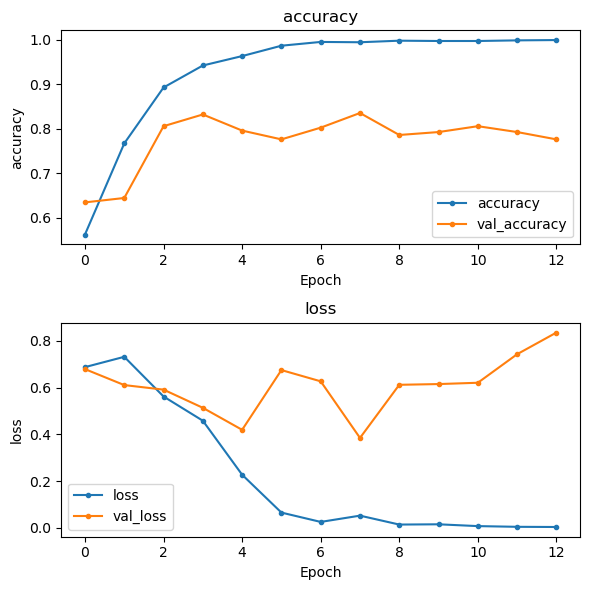


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       720
           1       1.00      1.00      1.00       698

    accuracy                           1.00      1418
   macro avg       1.00      1.00      1.00      1418
weighted avg       1.00      1.00      1.00      1418



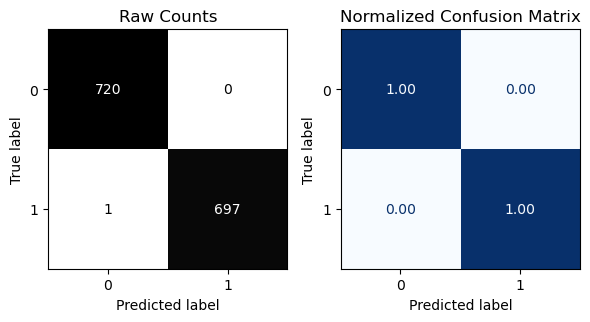


- Evaluating Training Data:
45/45 [==============================] - 1s 15ms/step - loss: 0.0030 - accuracy: 0.9993
{'loss': 0.00304125202819705, 'accuracy': 0.9992947578430176}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.70      0.79      0.74       152
           1       0.76      0.66      0.70       152

    accuracy                           0.72       304
   macro avg       0.73      0.72      0.72       304
weighted avg       0.73      0.72      0.72       304



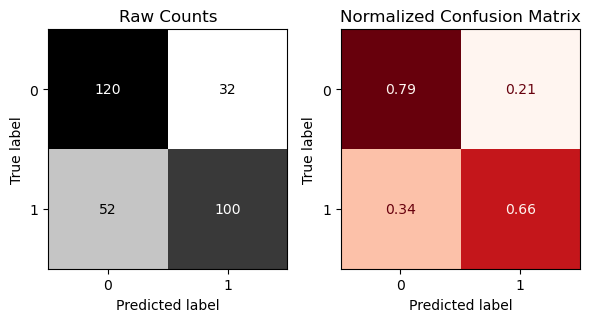


- Evaluating Test Data:
10/10 [==============================] - 0s 14ms/step - loss: 1.2111 - accuracy: 0.7237
{'loss': 1.2111115455627441, 'accuracy': 0.7236841917037964}


In [66]:
# Build the model
model = build_gru_model(sequence_vectorizer)
# Fit the model
EPOCHS = 30
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[early_stop],
)
# Evaluate the model
results = fn.evaluate_classification_network(
    model, X_train=train_ds, 
    X_test=test_ds, history=history);

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 150)              0         
 ectorization)                                                   
                                                                 
 embedding_2 (Embedding)     (None, 150, 100)          2306200   
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 32)                4256      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,310,489
Trainable params: 2,310,489
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
45/45 [==============================] - 2s 25ms/step - loss: 0.7019 - accuracy: 0.4725 - val_loss:

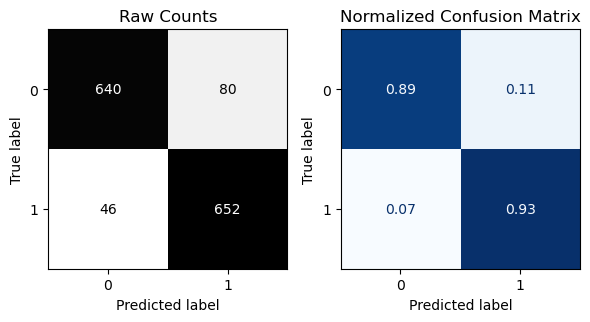


- Evaluating Training Data:
45/45 [==============================] - 0s 5ms/step - loss: 0.2718 - accuracy: 0.9111
{'loss': 0.27181383967399597, 'accuracy': 0.9111424684524536}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.51      0.42      0.46       152
           1       0.51      0.60      0.55       152

    accuracy                           0.51       304
   macro avg       0.51      0.51      0.51       304
weighted avg       0.51      0.51      0.51       304



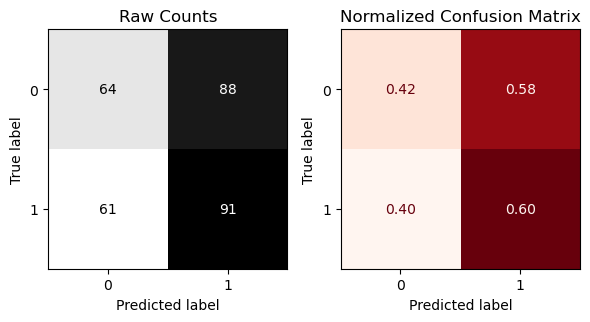


- Evaluating Test Data:
10/10 [==============================] - 0s 5ms/step - loss: 0.8486 - accuracy: 0.5099
{'loss': 0.8486493825912476, 'accuracy': 0.5098684430122375}


In [26]:
rnn_model = build_rnn_model(sequence_vectorizer)
EPOCHS = 30

# Fit the model
history = rnn_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[early_stop]
)
results = fn.evaluate_classification_network(
    rnn_model, X_train=train_ds, 
    X_test=test_ds,# history=history
);

- Our RNN model did not perform quite as well as the ML models. The RNN model has an accuracy of 51% while the ML model with the best parameters has 88%.